## LandCoverNet Source Imagery Extraction

<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

This tutorial delves into building a scalable model on the LandCoverNet dataset.



In [1]:
import getpass

MLHUB_API_KEY = getpass.getpass(prompt="MLHub API Key: ")
MLHUB_ROOT_URL = "https://api.radiant.earth/mlhub/v1"

MLHub API Key:  ································································


In [2]:
import pystac
import os
import itertools as it
import pystac_client
import requests
import shapely.geometry
import rioxarray
from pystac import Item
import planetary_computer
import stackstac
import rasterio.plot
import numpy as np
import dask

import contextlib
import warnings
from pystac.extensions.label import LabelExtension, LabelRelType
from urllib.parse import urljoin

warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

In [4]:
class MLHubSession(requests.Session):
    def __init__(self, *args, api_key=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.params.update({"key": api_key})

    def request(self, method, url, *args, **kwargs):
        url_prefix = MLHUB_ROOT_URL.rstrip("/") + "/"
        url = urljoin(url_prefix, url)
        return super().request(method, url, *args, **kwargs)


session = MLHubSession(api_key=MLHUB_API_KEY)

In [5]:
tmp_dir = "/home/jovyan/PlanetaryComputerExamples"
if not os.path.isdir(f"{tmp_dir}/landcovnet/labels"):
    os.makedirs(f"{tmp_dir}/landcovnet/labels") #create folder for labels to be stored

### Loading the source imagery

The esip-summer-2021-geospatial-ml tutorial was helpful in this task, which can be found at 

https://github.com/TomAugspurger/esip-summer-2021-geospatial-ml/blob/main/segmentation-model.ipynb

In [26]:
training_catalog = pystac.read_file(
    tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/collection.json"
)

In [7]:
from dask.distributed import Client

client = Client()
client.run(lambda: warnings.filterwarnings("ignore", "Creating an ndarray from ragged"))
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/daniel@radiant.earth/proxy/8787/status,
Dashboard: /user/daniel@radiant.earth/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41663,Workers: 4
Dashboard: /user/daniel@radiant.earth/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:38633,Total threads: 1
Dashboard: /user/daniel@radiant.earth/proxy/36015/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:34861,


In [27]:
links = training_catalog.get_item_links()

In [28]:
N_SCENES = 100
links = training_catalog.get_item_links()[:N_SCENES]
label_items = [link.resolve_stac_object().target for link in links]

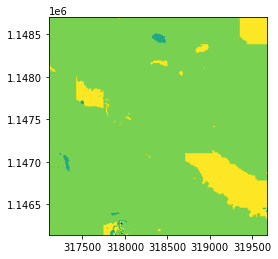

In [29]:
label_item = next(training_catalog.get_all_items())
rasterio.plot.show(rasterio.open(tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/"+label_item.id+"/labels.tif"));

In [11]:
label_item.geometry

{'coordinates': [[[37.32955714822882, 10.364020025810353],
   [37.3294343663916, 10.387163703120759],
   [37.35281134371039, 10.38728455271804],
   [37.35293240931304, 10.364140600401992],
   [37.32955714822882, 10.364020025810353]]],
 'type': 'Polygon'}

In [12]:
from ipyleaflet import Map, GeoJSON

data = {
    "type": "FeatureCollection",
    "features": [],
}
for label_item in label_items:
    data["features"].append(label_item.geometry)


center = shapely.geometry.shape(label_item.geometry).centroid.bounds[:2][::-1]

m = Map(center=(5.507814018809909, 13.617742928307308), zoom=2)
layer = GeoJSON(data=data)

m.add_layer(layer)
m.layout.max_width = "600px"

m

Map(center=[5.507814018809909, 13.617742928307308], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [13]:
# all the labels are from the same datetime
set([label_item.datetime for label_item in label_items])

{datetime.datetime(2018, 7, 1, 0, 0, tzinfo=tzlocal())}

In [14]:
label_item

<Item id=ref_landcovernet_v1_labels_31PGR_05>

In [15]:
bboxes = np.array([label_item.bbox for label_item in label_items])
mins = bboxes.min(0)
maxes = bboxes.max(0)
bbox = mins[0], mins[1], maxes[2], maxes[3]

In [16]:
def find_match(label_item, sentinel_items):
    # make sure we pick a sentinel scene that overlaps substantially with the label
    label_shape = shapely.geometry.shape(label_item.geometry)
    items2 = [
        item
        for item in sentinel_items
        if (
            shapely.geometry.shape(item.geometry).intersection(label_shape).area
            / label_shape.area
        )
        > 0.9
    ]
    sentinel_item=[]
    for item in items2:
        if (pystac.extensions.eo.EOExtension.ext(item).cloud_cover)==None:
            sentinel_item.append(item)
    return sentinel_item

In [48]:
def get_item(label_item, sentinel_items, assets):
    assets = list(assets)
    labels = rioxarray.open_rasterio(
        tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/"+label_item.id+"/labels.tif",
    ).squeeze()
    
    print(f"Attempting to find {label_item.id} from within sentinel items")
    sentinel_item = find_match(label_item, sentinel_items)
    bounds = tuple(round(x, 0) for x in labels.rio.bounds())
    print(f'Bounds of the label item: \n{bounds}')
    
    if not sentinel_item:
        print("No matching items found from find_match() method results")
    else:
        data = (
            stackstac.stack(
                #planetary_computer.sign(sentinel_item).to_dict(),
                assets=assets,
                dtype="float32",
                resolution=10,
                bounds=bounds,
                epsg=labels.rio.crs.to_epsg(),
            )
            .squeeze()
            .compute(scheduler="single-threaded")
        )
        #assert data.shape[1:] == labels.shape
        data = data.assign_coords(x=labels.x.data, y=labels.y.data)
        data /= 4000
        data = np.clip(data, 0, 1)
        return data, labels.astype("int64")
    return None, labels.astype("int64")

In [30]:
source_imagery_links = label_item.get_links(rel=LabelRelType.SOURCE)
links_limit = 10
for item in source_imagery_links:
    item.target= f'http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/{item.target[-54:-10]}'
print(f"Source Imagery Links: {len(source_imagery_links)}")
for link in it.islice(source_imagery_links, links_limit):
    print(f"- {link.href}")
if len(source_imagery_links) > links_limit:
    print("...")

Source Imagery Links: 72
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180102
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180107
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180112
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180117
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180122
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180127
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcovernet_v1_source_37PCM_22_20180201
- http://api.radiant.earth/mlhub/v1/collections/ref_landcovernet_v1_source/items/ref_landcove

In [33]:
image_item=[]
image_link = source_imagery_links
for link in image_link:
    response = session.get(link.href)
    image_item.append(Item.from_dict(response.json()))
# print(f"Item ID: {image_item.id}")
# print("Assets:")
# for asset_key, asset in image_item.assets.items():
#     print(f"- Asset Key: {asset_key}")
#     asset_eo_ext = EOExtension.ext(asset)
#     if asset_eo_ext.bands is not None:
#         band_names = ", ".join(band.common_name for band in asset_eo_ext.bands)
#         print(f"  Bands:{band_names}")

In [88]:
# get_item_ = dask.delayed(get_item, nout=2)
# assets = ("B03", "B04", "B05")

# Xys = [get_item_(label_item, source_imagery_links, assets) for label_item in label_items]
# Xys = dask.persist(*Xys)

# Xys = dask.compute(*Xys)

In [58]:
#image_item[0]

distributed.utils_perf - WARNING - full garbage collections took 68% CPU time recently (threshold: 10%)


In [57]:
get_item_ = dask.delayed(get_item, nout=2)
assets = ("B03", "B04", "B05")

Xys = [get_item_(label_item, image_item, assets) for label_item in label_items]
Xys = dask.persist(*Xys)

Xys = dask.compute(*Xys)

distributed.utils_perf - WARNING - full garbage collections took 77% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 77% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 77% CPU time recently (threshold: 10%)
distributed.worker - WARNING - Compute Failed
Function:  execute_task
args:      ((<function get_item at 0x7f4c1b069550>, <Item id=ref_landcovernet_v1_labels_37PCM_22>, [<Item id=ref_landcovernet_v1_source_37PCM_22_20180102>, <Item id=ref_landcovernet_v1_source_37PCM_22_20180107>, <Item id=ref_landcovernet_v1_source_37PCM_22_20180112>, <Item id=ref_landcovernet_v1_source_37PCM_22_20180117>, <Item id=ref_landcovernet_v1_source_37PCM_22_20180122>, <Item id=ref_landcovernet_v1_source_37PCM_22_20180127>, <Item id=ref_landcovernet_v1_source_37PCM_22_20180201>, <Item id=ref_landcovernet_v1_source_37PCM_22_20180206>, <Item id=ref_landcovernet_v1_source_37PCM_22_20180211>, <Item id=ref_l

TypeError: stack() missing 1 required positional argument: 'items'

Attempting to find ref_landcovernet_v1_labels_33KUT_14 from within sentinel items
Bounds of the label item: 
(361040.0, 7772420.0, 363600.0, 7774980.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_37PCM_16 from within sentinel items
Bounds of the label item: 
(323880.0, 1183710.0, 326440.0, 1186270.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_33KUT_19 from within sentinel items
Bounds of the label item: 
(334240.0, 7786350.0, 336800.0, 7788910.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_36MWU_05 from within sentinel items
Bounds of the label item: 
(501350.0, 9337240.0, 503910.0, 9339800.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_36MWT_17 from within sentinel items
Bounds of the label item: 
(504530.0, 9267230.0, 507090.0, 9269790.0)
No matching 

distributed.utils_perf - WARNING - full garbage collections took 68% CPU time recently (threshold: 10%)


Bounds of the label item: 
(755390.0, 457510.0, 757950.0, 460070.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_34MBC_28 from within sentinel items
Bounds of the label item: 
(258200.0, 9705470.0, 260760.0, 9708030.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_37NGE_10 from within sentinel items
Bounds of the label item: 
(784790.0, 440420.0, 787350.0, 442980.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_38PKQ_02 from within sentinel items
Bounds of the label item: 
(211370.0, 968010.0, 213930.0, 970570.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labels_32PLS_07 from within sentinel items
Bounds of the label item: 
(339900.0, 1115230.0, 342460.0, 1117790.0)
No matching items found from find_match() method results
Attempting to find ref_landcovernet_v1_labe

distributed.utils_perf - WARNING - full garbage collections took 70% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 71% CPU time recently (threshold: 10%)


In [41]:
len(Xys)

100

In [51]:
Xys[-1]

Delayed('get_item-51d97eeb-ef22-4846-aac7-d8ce3d10f509')

In [39]:
len(Xys)

100